In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from rdkit import Chem

from tqdm.notebook import tqdm

import score_utils
import multiprocessing as mp
import numpy as np

In [2]:
deet = Chem.MolFromSmiles("CCN(CC)C(=O)c1cccc(C)c1")
deet.GetNumAtoms()

14

### Read files and clean up

In [3]:
da = pd.read_csv("./docking_scores/DEET_amides_scores.csv")
de = pd.read_csv("./docking_scores/DEET_reaction_enumeration_scores.csv")

In [4]:
da.columns = ["ID","score","d"]
da["smiles"] = da.index
da['source'] = ["amide"] * len(da)
da.drop("d",axis=1,inplace=True)

In [5]:
da["posN"] =  ["N+" in i for i in da.smiles]
da = da[~da.posN].copy()
da.reset_index(drop=True,inplace=True)

In [6]:
da.drop("posN",axis=1,inplace=True)

In [7]:
de.columns = ["ID","score","d"]
de["smiles"] = de.index
de.reset_index(drop=True,inplace=True)
de['source'] = ["enumerated"] * len(de)
de.drop("d",axis=1,inplace=True)
de = de[~de.score.isnull()].copy()

### Get HAC for amide set

In [8]:
if __name__ == '__main__':
    with mp.Pool(16) as p:
        n_atoms = p.map(score_utils.count_atoms, da.smiles,chunksize=10000)

In [9]:
da["ntoms"] = n_atoms

da = da[~da.score.isnull()].copy()

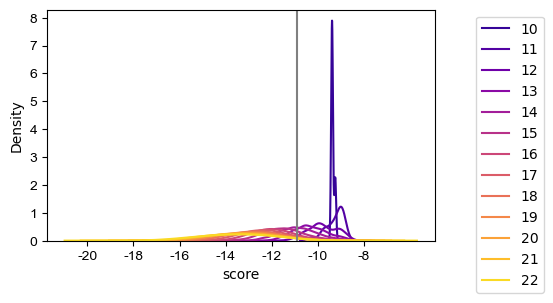

In [10]:
# Plot score distributions across HAC
sns.set_palette("plasma",n_colors=13)

plt.figure(figsize=(5,3))
for n_at in range(10,23):
    df_plot = da[da.ntoms <= n_at]
    sns.kdeplot(data=df_plot,x="score")
    
ax = plt.gca()
    
ax.set_xticks(range(-20,-7,2))
ax.set_xticklabels(range(-20,-7,2),font="Arial")

ax.set_yticks(range(0,9,1))
ax.set_yticklabels(range(0,9,1),font="Arial")

plt.legend(labels=[str(i) for i in range(10,23)],bbox_to_anchor=(1.3, 1.0), loc='upper right')
    
# plt.legend(labels=[str(i) for i in range(10,23)])
plt.gca().axvline(-10.904342,color="grey")
plt.savefig("deet_1022_kde.svg",format="svg")

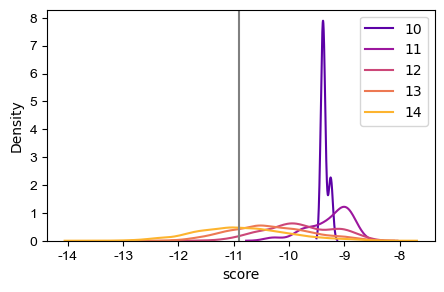

In [11]:
sns.set_palette("plasma",n_colors=5)

plt.figure(figsize=(5,3))
for n_at in range(10,15):
    df_plot = da[da.ntoms <= n_at]
    sns.kdeplot(data=df_plot,x="score")
    
ax = plt.gca()
    
ax.set_xticks(range(-14,-7,1))
ax.set_xticklabels(range(-14,-7,1),font="Arial")

ax.set_yticks(range(0,9,1))
ax.set_yticklabels(range(0,9,1),font="Arial")

plt.legend(labels=[str(i) for i in range(10,15)],bbox_to_anchor=(1.3, 1.0), loc='upper right')
    
plt.legend(labels=[str(i) for i in range(10,15)])
plt.gca().axvline(-10.904342,color="grey")

plt.savefig("deet_1014_kde.svg",format="svg")

In [12]:
if __name__ == '__main__':
    with mp.Pool(12) as p:
        deet_base = p.map(score_utils.has_deet_base, de.smiles,chunksize=10000)

In [13]:
if __name__ == '__main__':
    with mp.Pool(12) as p:
        aro = p.map(score_utils.has_aromaticity, de.smiles,chunksize=10000)

In [ ]:
# Read reaction distances
dist_dict = {}

for file_tag in tqdm(range(56)):

    file_string = str(file_tag).zfill(2)

    data = pd.read_csv(f"../data_files/smiles_with_all_dists/smiles_with_all_dists_{file_string}.csv")

    data["tag"] = file_tag*1000000 + data.index
    
    for r in data.itertuples():
        dist_dict[r.tag] = r.ac2_am3

  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
de["deet_base"] = deet_base
de["aro"] = aro

de["tag"] = [int(i.split("_")[0]) for i in de["ID"] ]

de["dist"] = [dist_dict[i] for i in de.tag]

de.rename({"deet_base":"has_ring","aro":"aromatic"},axis=1,inplace=True)

In [ ]:
sns.set_palette("plasma",n_colors=3)
sns.kdeplot(data=de, x="score", hue="has_ring")
plt.gca().axvline(-10.904342,color="grey")

In [ ]:
sns.set_palette("plasma",n_colors=3)
sns.kdeplot(data=de, x="score", hue="aromatic")
plt.gca().axvline(-10.904342,color="grey")

In [ ]:
da_plot = da[da.ntoms <= 15].copy()
da_plot.drop("ntoms",inplace=True,axis=1)

In [ ]:
de_plot = de[(de.aromatic) & (de.dist<=6)].copy()
de_plot.drop(["has_ring", "aromatic","tag","dist"],axis=1,inplace=True)

In [ ]:
d_all = pd.concat((da_plot,de_plot))

d_all.reset_index(drop=True,inplace=True)

# d_all.sort_values("source",ascending=False)

In [ ]:
da_avg = np.mean(da_plot.score)
de_avg = np.mean(de_plot.score)

In [ ]:
sns.set_palette("plasma",n_colors=3)
# sns.set(style="white", rc={"axes.facecolor": (1, 1, 1, 1)},font_scale=1.5)
sns.kdeplot(data=d_all.sort_values("source",ascending=False), x="score",hue="source",clip_on=True,fill=True,bw_method=0.2)
ax = plt.gca()
ax.set_xticks((-15,-10,-5))
ax.axvline(da_avg,color="orange")
ax.axvline(de_avg,color="purple")
# ax.legend(labels=("e","a"))
# plt.gca().axvline(-10.904342,color="grey")
ax.set_title("deet")
# plt.savefig("DEET_score_compare.svg",format="svg")